In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob


In [8]:
def calculate_green_percentage(image_path, show_visualization=True):
    try:
        image = Image.open(image_path)
        
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        img_array = np.array(image)
        
        r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]
        
        def rgb_to_hsv(r, g, b):
            r, g, b = r/255.0, g/255.0, b/255.0
            max_val = np.maximum(np.maximum(r, g), b)
            min_val = np.minimum(np.minimum(r, g), b)
            diff = max_val - min_val
            
            h = np.zeros_like(max_val)
            mask = diff != 0
            
            red_max = (max_val == r) & mask
            h[red_max] = (60 * ((g[red_max] - b[red_max]) / diff[red_max]) + 360) % 360
            
            green_max = (max_val == g) & mask
            h[green_max] = (60 * ((b[green_max] - r[green_max]) / diff[green_max]) + 120) % 360
            
            blue_max = (max_val == b) & mask
            h[blue_max] = (60 * ((r[blue_max] - g[blue_max]) / diff[blue_max]) + 240) % 360
            
            s = np.zeros_like(max_val)
            s[max_val != 0] = diff[max_val != 0] / max_val[max_val != 0]
            
            v = max_val
            
            return h, s, v
        
        h, s, v = rgb_to_hsv(r, g, b)
    
        hsv_green = (h >= 60) & (h <= 180) & (s >= 0.15) & (v >= 0.2)
        
    
        yellow_green = (
            (h >= 45) & (h <= 85) &   
            (s >= 0.1) &             
            (v >= 0.25) &            
            (g > b * 1.1) &           
            ((g + r) > b * 1.8)       
        )
        
       
        vegetation_green = (
            (g >= r * 0.9) &  
            (g >= b * 0.9) &  
            (g > 40) &        
            (s > 0.1) &       
            (v > 0.15)        
        )
        
        final_green_mask = (
            hsv_green |        
            yellow_green |      
            vegetation_green    
        )
         
        from scipy import ndimage
        try:
           
            final_green_mask = ndimage.binary_opening(final_green_mask, structure=np.ones((2,2)))
            final_green_mask = ndimage.binary_closing(final_green_mask, structure=np.ones((3,3)))
        except ImportError:
            
            kernel = np.ones((3,3), dtype=bool)
            
            eroded = ndimage.binary_erosion(final_green_mask, kernel) if 'ndimage' in locals() else final_green_mask
            final_green_mask = ndimage.binary_dilation(eroded, kernel) if 'ndimage' in locals() else final_green_mask
        

        total_pixels = img_array.shape[0] * img_array.shape[1]
        green_pixels = np.sum(final_green_mask)
        green_percentage = (green_pixels / total_pixels) * 100
        
        if show_visualization:
            
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            
            axes[0,0].imshow(img_array)
            axes[0,0].set_title('Original Image')
            axes[0,0].axis('off')
            
            axes[0,1].imshow(hsv_green, cmap='Greens')
            axes[0,1].set_title('HSV Green Detection')
            axes[0,1].axis('off')
            
            axes[0,2].imshow(yellow_green, cmap='Greens')
            axes[0,2].set_title('Yellow-Green Detection')
            axes[0,2].axis('off')
            
            axes[1,0].imshow(vegetation_green, cmap='Greens')
            axes[1,0].set_title('Vegetation Detection')
            axes[1,0].axis('off')
            
            axes[1,1].imshow(final_green_mask, cmap='Greens')
            axes[1,1].set_title(f'Combined Result\n({green_percentage:.2f}% green)')
            axes[1,1].axis('off')
            
            overlay = img_array.copy()
            overlay[final_green_mask] = [0, 255, 0]  
            axes[1,2].imshow(overlay)
            axes[1,2].set_title('Green Areas Highlighted')
            axes[1,2].axis('off')
            
            plt.tight_layout()
            plt.show()
        
            fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))
            
         
            axes2[0].imshow(h, cmap='hsv')
            axes2[0].set_title('Hue Channel')
            axes2[0].axis('off')
            
   
            axes2[1].imshow(s, cmap='gray')
            axes2[1].set_title('Saturation Channel')
            axes2[1].axis('off')
            
         
            axes2[2].imshow(v, cmap='gray')
            axes2[2].set_title('Value (Brightness) Channel')
            axes2[2].axis('off')
            
            plt.tight_layout()
            plt.show()
        
        return green_percentage
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

In [9]:
def analyze_desktop_images(desktop_path=None):

  
    if desktop_path is None:
        desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    
    print(f"Scanning images in: {desktop_path}")
    

    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.tif']
    

    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(desktop_path, ext)))
        image_files.extend(glob.glob(os.path.join(desktop_path, ext.upper())))
    
    if not image_files:
        print("No image files found on desktop!")
        return {}
    
    print(f"Found {len(image_files)} image files")
    
    results = {}
    
    for i, image_path in enumerate(image_files):
        print(f"\nProcessing {i+1}/{len(image_files)}: {os.path.basename(image_path)}")
        
        green_percentage = calculate_green_percentage(image_path, show_visualization=False)
        
        if green_percentage is not None:
            results[os.path.basename(image_path)] = green_percentage
            print(f"Green percentage: {green_percentage:.2f}%")
        else:
            print("Failed to process image")
    
    return results

In [10]:
def save_results_to_downloads(results):
 
    import csv
    import json
    from datetime import datetime
    
    if not results:
        print("No results to save")
        return

    downloads_path = os.path.join(os.path.expanduser("~"), "Downloads")
    

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    csv_filename = f"green_percentage_analysis_{timestamp}.csv"
    csv_filepath = os.path.join(downloads_path, csv_filename)
    
    try:
        with open(csv_filepath, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Image_Name', 'Green_Percentage'])
            
            sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
            
            for filename, percentage in sorted_results:
                writer.writerow([filename, f"{percentage:.2f}"])
        
        print(f"✓ CSV results saved to: {csv_filepath}")
        
    except Exception as e:
        print(f"Error saving CSV: {str(e)}")
 
    json_filename = f"green_percentage_analysis_{timestamp}.json"
    json_filepath = os.path.join(downloads_path, json_filename)
    
    try:
  
        percentages = list(results.values())
        statistics = {
            "average_green_percentage": round(np.mean(percentages), 2),
            "maximum_green_percentage": round(np.max(percentages), 2),
            "minimum_green_percentage": round(np.min(percentages), 2),
            "standard_deviation": round(np.std(percentages), 2),
            "total_images_analyzed": len(results),
            "analysis_timestamp": datetime.now().isoformat()
        }
        
        json_data = {
            "analysis_summary": statistics,
            "individual_results": {filename: round(percentage, 2) for filename, percentage in results.items()},
            "sorted_results": [{"image": filename, "green_percentage": round(percentage, 2)} 
                             for filename, percentage in sorted(results.items(), key=lambda x: x[1], reverse=True)]
        }
        
        with open(json_filepath, 'w', encoding='utf-8') as jsonfile:
            json.dump(json_data, jsonfile, indent=2, ensure_ascii=False)
        
        print(f"✓ JSON results saved to: {json_filepath}")
        
    except Exception as e:
        print(f"Error saving JSON: {str(e)}")
    

    txt_filename = f"green_percentage_summary_{timestamp}.txt"
    txt_filepath = os.path.join(downloads_path, txt_filename)
    
    try:
        with open(txt_filepath, 'w', encoding='utf-8') as txtfile:
            txtfile.write("GREEN PERCENTAGE ANALYSIS SUMMARY\n")
            txtfile.write("=" * 50 + "\n")
            txtfile.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            txtfile.write(f"Total Images Analyzed: {len(results)}\n\n")
            

            txtfile.write("INDIVIDUAL RESULTS:\n")
            txtfile.write("-" * 50 + "\n")
            sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
            for filename, percentage in sorted_results:
                txtfile.write(f"{filename:<35} : {percentage:>6.2f}%\n")
            

            percentages = list(results.values())
            txtfile.write("\n" + "STATISTICS:\n")
            txtfile.write("-" * 50 + "\n")
            txtfile.write(f"Average green percentage: {np.mean(percentages):.2f}%\n")
            txtfile.write(f"Maximum green percentage: {np.max(percentages):.2f}%\n")
            txtfile.write(f"Minimum green percentage: {np.min(percentages):.2f}%\n")
            txtfile.write(f"Standard deviation: {np.std(percentages):.2f}%\n")
        
        print(f"✓ Summary saved to: {txt_filepath}")
        
    except Exception as e:
        print(f"Error saving summary: {str(e)}")


In [13]:
def display_results_summary(results):
    if not results:
        print("No results to display")
        return
    
    print("\n" + "="*50)
    print("GREEN PERCENTAGE ANALYSIS SUMMARY")
    print("="*50)
    
  
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    for filename, percentage in sorted_results:
        print(f"{filename:<30} : {percentage:>6.2f}%")

    percentages = list(results.values())
    print("\n" + "-"*50)
    print("STATISTICS:")
    print(f"Average green percentage: {np.mean(percentages):.2f}%")
    print(f"Maximum green percentage: {np.max(percentages):.2f}%")
    print(f"Minimum green percentage: {np.min(percentages):.2f}%")
    print(f"Standard deviation: {np.std(percentages):.2f}%")

    print("\n" + "-"*50)
    print("SAVING RESULTS...")
    save_results_to_downloads(results)

    plt.figure(figsize=(12, 6))
    filenames = [name[:20] + '...' if len(name) > 20 else name for name, _ in sorted_results]
    percentages = [perc for _, perc in sorted_results]
    
    plt.bar(range(len(filenames)), percentages, color='green', alpha=0.7)
    plt.xlabel('Images')
    plt.ylabel('Green Percentage (%)')
    plt.title('Green Percentage in Desktop Images')
    plt.xticks(range(len(filenames)), filenames, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Simplified Green Zone Calculator
Using only HSV, Yellow-Green, and Vegetation detection methods
✓ SciPy available - using advanced morphological operations
Scanning images in: C:\Users\quangng\Desktop
Found 26 image files

Processing 1/26: Apr.png
Green percentage: 22.88%

Processing 2/26: Aug.png
Green percentage: 55.64%

Processing 3/26: Dec.png
Green percentage: 44.38%

Processing 4/26: Feb.png
Green percentage: 39.81%

Processing 5/26: images.png
Error processing C:\Users\quangng\Desktop\images.png: [Errno 13] Permission denied: 'C:\\Users\\quangng\\Desktop\\images.png'
Failed to process image

Processing 6/26: Jan.png
Green percentage: 16.16%

Processing 7/26: Jul.png
Green percentage: 28.72%

Processing 8/26: Jun.png
Green percentage: 34.44%

Processing 9/26: Mar.png
Green percentage: 10.04%

Processing 10/26: May.png
Green percentage: 49.88%

Processing 11/26: Nov.png
Green percentage: 43.58%

Processing 12/26: Oct.png
Green percentage: 44.45%

Processing 13/26: Sep.png
Green pe

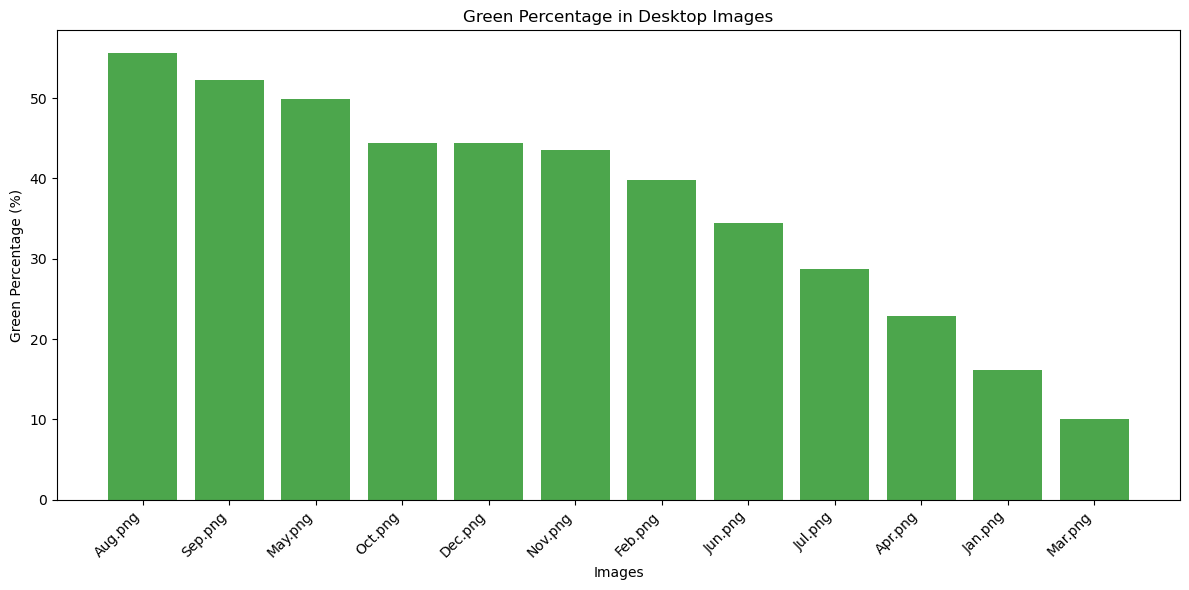


Would you like to see detailed analysis of any specific image?
Available images:
1. Apr.png
2. Aug.png
3. Dec.png
4. Feb.png
5. Jan.png
6. Jul.png
7. Jun.png
8. Mar.png
9. May.png
10. Nov.png
11. Oct.png
12. Sep.png



Enter image number for detailed view (or press Enter to skip):  11



Simplified analysis of: Oct.png
Showing HSV, Yellow-Green, and Vegetation detection methods...


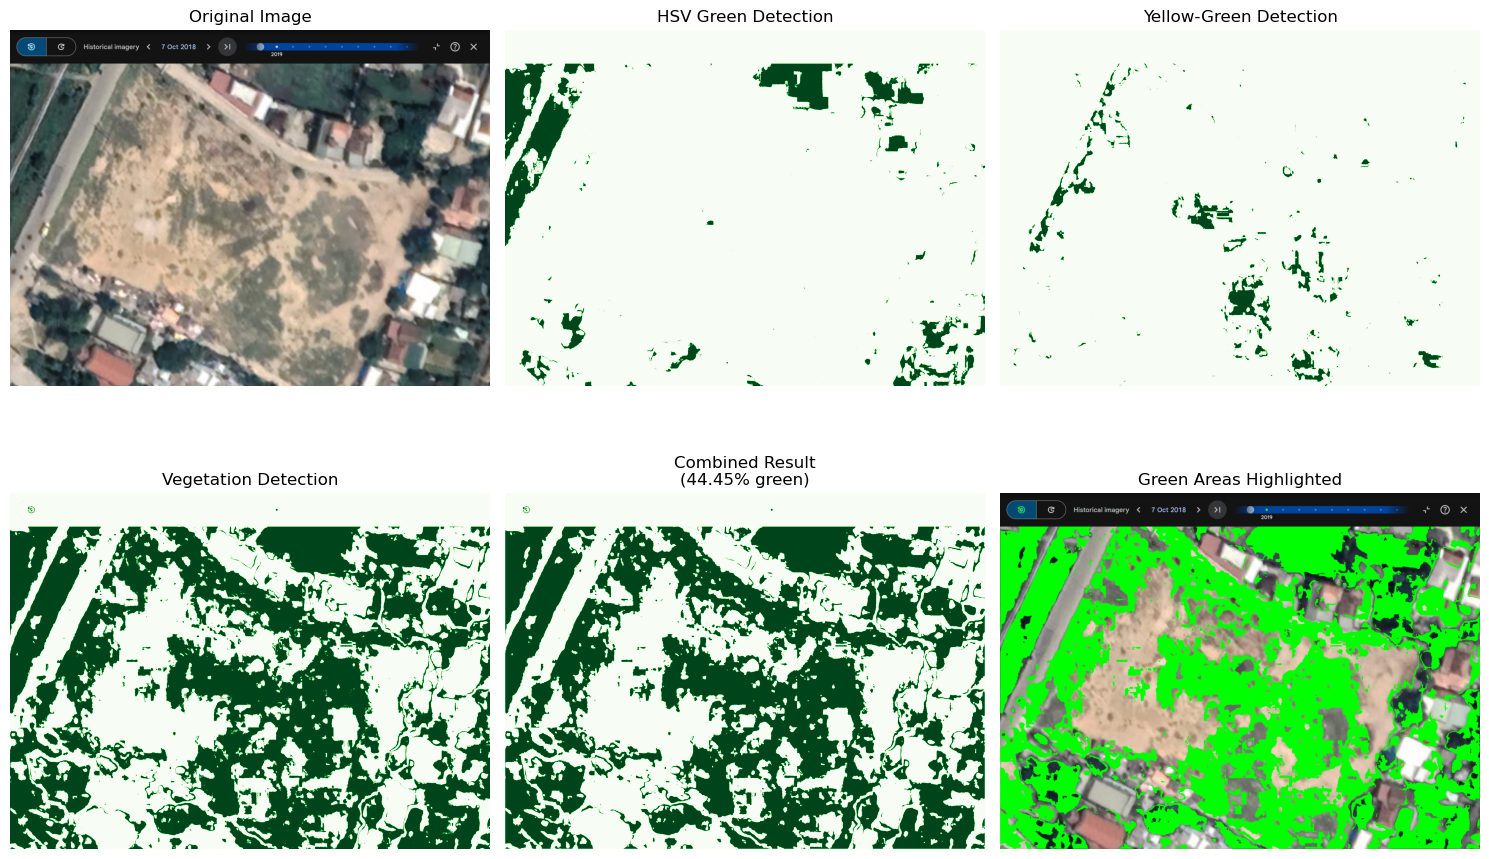

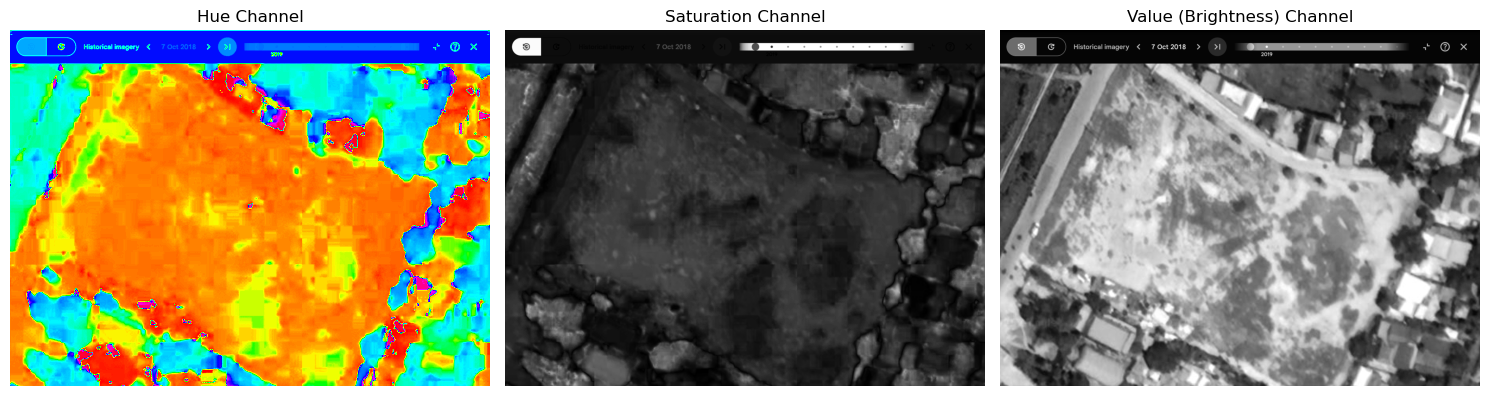

In [14]:
# Main execution
if __name__ == "__main__":
    print("Simplified Green Zone Calculator")
    print("===============================")
    print("Using only HSV, Yellow-Green, and Vegetation detection methods")
    
    try:
        from scipy import ndimage
        print("✓ SciPy available - using advanced morphological operations")
    except ImportError:
        print("⚠ SciPy not available - install with 'pip install scipy' for better results")

    results = analyze_desktop_images()
    
    if results:
        display_results_summary(results)
        
        print(f"\nWould you like to see detailed analysis of any specific image?")
        print("Available images:")
        for i, filename in enumerate(results.keys(), 1):
            print(f"{i}. {filename}")
        
        try:
            choice = input("\nEnter image number for detailed view (or press Enter to skip): ")
            if choice.strip():
                choice_idx = int(choice) - 1
                filenames = list(results.keys())
                if 0 <= choice_idx < len(filenames):
                    selected_file = filenames[choice_idx]
                    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
                    image_path = os.path.join(desktop_path, selected_file)
                    print(f"\nSimplified analysis of: {selected_file}")
                    print("Showing HSV, Yellow-Green, and Vegetation detection methods...")
                    calculate_green_percentage(image_path, show_visualization=True)
        except (ValueError, IndexError):
            print("Invalid selection")
